# **Business case :**
## **To Enable Early Detection of Major Rice Plant Diseases like Brown spot, Bacterial leaf blight, Leaf smut  Using CNN.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import files
import zipfile
import os


uploaded = files.upload()  # Uploading zip file

with zipfile.ZipFile("Data.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


print(os.listdir("dataset"))


Saving Data.zip to Data.zip
['Data']


In [4]:
def get_image_shapes_by_class(root_dir, max_per_class=50):
    data = []
    for class_name in os.listdir('dataset/Data'):
        class_dir = os.path.join('dataset/Data', class_name)
        collected = 0


        for root, dirs, files in os.walk(class_dir): # To collect all images
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    try:
                        img_path = os.path.join(root, file)
                        with Image.open(img_path) as img:
                            width, height = img.size
                            data.append({"Class": class_name, "Width": width, "Height": height})
                            collected += 1
                            if collected >= max_per_class:
                                break
                    except:
                        continue
            if collected >= max_per_class:
                break
    return pd.DataFrame(data)



In [5]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "dataset/Data",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

print("Classes:", train_generator.class_indices)
print("Number of samples:", train_generator.samples)


Found 119 images belonging to 3 classes.
Classes: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}
Number of samples: 119


# **EDA**

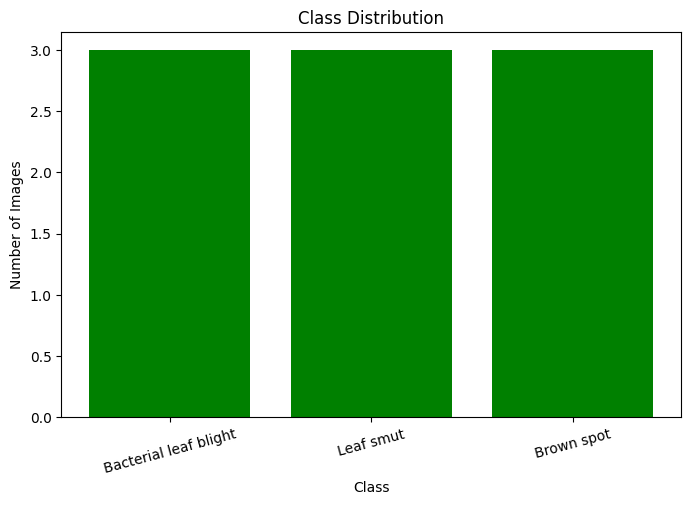

In [6]:
import matplotlib.pyplot as plt

class_counts = {}
for class_name in os.listdir("dataset/Data"):
    class_path = os.path.join("dataset/Data", "dataset/Data")
    if os.path.isdir("dataset/Data"):
        class_counts[class_name] = len(os.listdir("dataset/Data"))

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='green')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=15)
plt.show()


In [7]:
path = "dataset/Data"

valid_exts = ('.jpg', '.jpeg')

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    total = 0
    for root, _, files in os.walk(folder_path):
        total += len([f for f in files if f.lower().endswith(valid_exts)])
    print(f"{folder}: {total} images")


Bacterial leaf blight: 40 images
Leaf smut: 39 images
Brown spot: 40 images


# **Data regularization & Augmentation**

In [8]:
#Model_Creation

# Adam + weight decay
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # 3 classes
])

from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# **DATA AUGMENTATION**

In [9]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.1
)
train_generator = datagen.flow_from_directory(
    "dataset/Data",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 119 images belonging to 3 classes.


In [10]:
history = model.fit(
    train_generator,
    epochs = 25)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.2924 - loss: 1.1176
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4051 - loss: 1.0819
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4301 - loss: 1.0729
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.4523 - loss: 1.0747
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5708 - loss: 0.9799
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5531 - loss: 0.9654
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5618 - loss: 0.9367
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5730 - loss: 0.9370
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5629 - loss: 0.8871
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.6887 - loss: 0.8204
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.6767 - loss: 0.8150
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.6340 - loss: 0.8020
Epoch 13/25
4

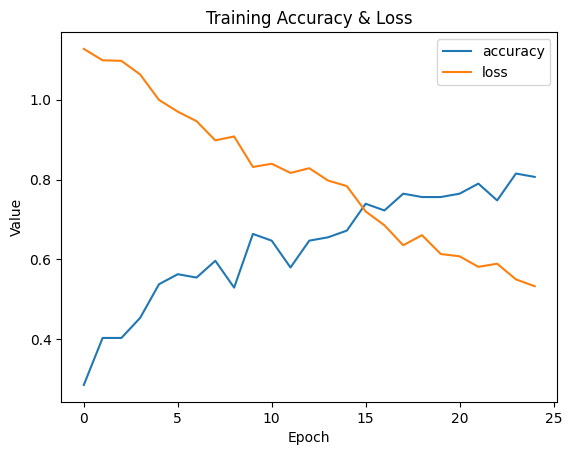

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Training Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


# **INSIGHTS**
* Training accuracy improves steadily from \~82% to 90% over 25 epochs which indicates model is becoming more accurate and reliable on the training set with each epoch.
* Training loss decreases consistently from \~0.42 to 0.32, showing effective learning and optimizing well, as it's minimizing the cost function used during training.
* Accuracy and loss curves are stable, indicating a smooth and well-tuned training process.


In [12]:
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)



Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


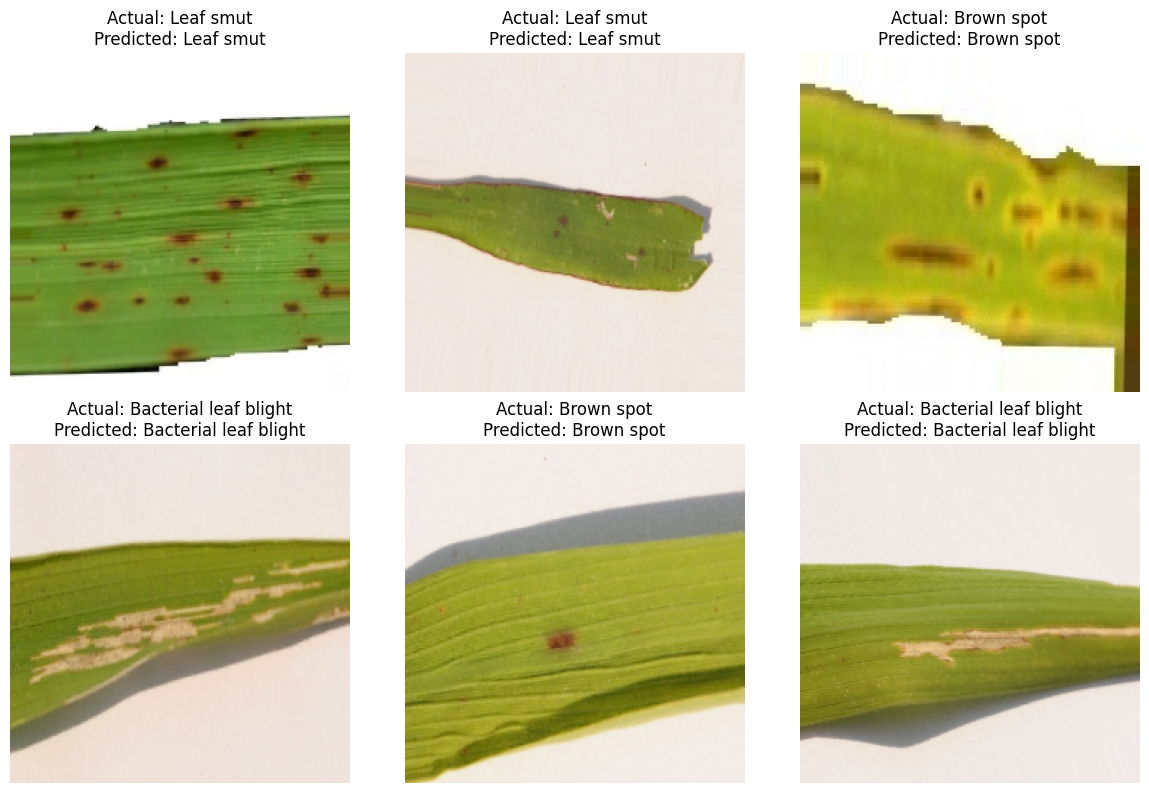

In [16]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Predict
preds = model.predict(images)
predicted_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)

# Plot a few
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Actual: {class_names[true_classes[i]]}\nPredicted: {class_names[predicted_classes[i]]}")
plt.tight_layout()
plt.show()


# **CHALLENGES FACED**
1. **File Handling** :
 * File paths were initially hardcoded, making the file less portable across systems.
 * Directory structure assumptions caused errors if any folder was missing or renamed.
2. **Model Training Issues** :
 * Overfitting observed: training accuracy high
 * Needed careful tuning of dropout layers and augmentations to mitigate overfitting.
 * No pre-trained models used initially, limiting model performance on a small dataset.
3. **Data Augmentation Limitations** :
 * Although augmentation helped, it couldn't fully substitute for real, diverse image data.
 * Selecting the right parameters (like rotation range or zoom) were required experimentation.

